In [1]:
import pandas as pd

nifty50_df = pd.read_csv('nifty50.csv')

replaced_tickers = pd.read_csv('nifty50_changes.csv')
stock_changes = pd.read_csv('nifty50_changes.csv')
stock_changes['start_date'] = pd.to_datetime(stock_changes['start_date'])
stock_changes['end_date'] = pd.to_datetime(stock_changes['end_date'])

tickers = [f"NSE:{t}-EQ" for t in set(nifty50_df['Symbol'].tolist())] + stock_changes.symbol.tolist()

In [2]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "/workspaces/codespaces-jupyter/data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

Error fetching data for NSE:HDFC-EQ: 'candles'


Loading 1Dmin data: 100%|██████████| 62/62 [00:01<00:00, 55.88it/s]


In [3]:
df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()

In [4]:
import talib as ta

df.Date = pd.to_datetime(df.Date)
# Calculate RSI per stock
df['SMA20'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=20))
df['SMA20_Perc_Distance'] = (df['Close'] - df['SMA20']) / df['SMA20'] * 100

df['Entry_Price'] = df.groupby('Stock')['Close'].shift(-1)
df['Entry_Time'] = df.groupby('Stock')['Date'].shift(-1)

# df = df[df.Date >= '2020-01-01 05:30:00']

In [5]:
signals = (
    df[df.Close < df.SMA20].groupby('Date', group_keys=False).apply(lambda x: x.nsmallest(5, "SMA20_Perc_Distance"))
      .sort_values(['Date', 'SMA20_Perc_Distance']).reset_index(drop=True).dropna(subset=['Entry_Price'])
)

/tmp/ipykernel_14311/960733863.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[df.Close < df.SMA20].groupby('Date', group_keys=False).apply(lambda x: x.nsmallest(5, "SMA20_Perc_Distance"))


In [18]:
from dataclasses import asdict
from tqdm.notebook import tqdm
from lib import PositionManager, Bank

rebalance_perc = 100
max_holding_period = 5000  # days
max_num_of_avgs = 3
initial_capital = 1000000
leverage = 1
tp_perc = 3.14
sl_perc = 100
max_positions_num = 15
mtf_rate_daily = 0.0192 / 100  # Margin funding rate (per day)


def select_stock_for_entry(pm, signals: pd.DataFrame):
    selected_stocks = []
    for _, signal in signals.iterrows():
        if pm.get_position(signal.Stock) is None:
            if signal.Stock in stock_changes.symbol.tolist():
                stock = stock_changes[stock_changes.symbol == signal.Stock]
                if signal.Date >= stock.start_date.values[0] and signal.Date <= stock.end_date.values[0]:
                    selected_stocks.append(signal)
            else:
                selected_stocks.append(signal)
    return selected_stocks[0] if len(selected_stocks) > 0 else None


def init_new_position(k, v, pm):
    selected_stock = select_stock_for_entry(pm, signals[signals.Date == k])
    if selected_stock is None:
        return None

    return pm.new_position(selected_stock.Stock, selected_stock.Entry_Time, selected_stock.Entry_Price)    

def avg_out_active_positions(k, v, pm):
    global max_num_of_avgs
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
        .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Close', 'Entry_Time', 'Entry_Price']])
    )
    apdf['perc_change'] = (apdf.Close - apdf.last_entry_price)/apdf.last_entry_price * 100
    rebalance_stocks = apdf[apdf.perc_change <= -rebalance_perc].sort_values('perc_change')
    if len(rebalance_stocks) == 0:
        return

    for k, stock in rebalance_stocks.iterrows():
        position = pm.get_position(stock.name)
        if len(position.trades) == max_num_of_avgs:
            continue

        pm.add_trade_to_position(stock.name, stock.Entry_Time, stock.Entry_Price)
        break

def book_profit(k, v, pm):
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['High', 'Close', 'Date']])
    )
    apdf = apdf[apdf.High >= apdf.tp]
    apdf['perc_change'] = (apdf.Close - apdf.avg_entry_price)/apdf.avg_entry_price * 100

    selected_stocks = apdf.sort_values('perc_change', ascending=False)
    if len(selected_stocks) > 0:
        selected_stock = selected_stocks.iloc[0]
        pm.close_position(selected_stock.name, selected_stock.Date, selected_stock.tp)


def exit_long_running_positions(k, v, pm):
    global active_positions
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Date', 'Close']])
    )
    apdf['holding_period'] = (k - apdf.entry_time).dt.days
    long_running_positions = apdf[apdf.holding_period >= max_holding_period]
    
    for stock, lr_position in long_running_positions.iterrows():
        pm.close_position(stock, lr_position.Date, lr_position.Close)
        
def book_loss(k, v, pm):
    if not pm.has_active_positions():
        return

    apdf = (
        pd.DataFrame([asdict(p) for p in pm.get_active_positions() if p is not None]).set_index('stock')
            .join(v.rename(columns={'Stock': 'stock'}).set_index('stock')[['Low', 'Close', 'Date']])
    )
    apdf = apdf[apdf.Low <= apdf.sl]
    apdf['perc_change'] = (apdf.avg_entry_price - apdf.Close)/apdf.avg_entry_price * 100

    selected_stocks = apdf.sort_values('perc_change', ascending=False)
    for selected_stock in selected_stocks.itertuples():
        pm.close_position(selected_stock.Index, selected_stock.Date, selected_stock.sl)
        
def exit_if_removed_from_index(k, v, pm):
    global active_positions
    if not pm.has_active_positions():
        return

    for p in pm.get_active_positions():
        if p.stock not in stock_changes.symbol.tolist():
            continue
        stock = stock_changes[stock_changes.symbol == p.stock]
        if k > stock.end_date.values[0]:
            pm.close_position(p.stock, k, v[v.Stock == p.stock].Close.values[0])

def exit_position(k, v, pm):
    book_profit(k, v, pm)
    # book_loss(k, v, pm)
    exit_if_removed_from_index(k, v, pm)
    exit_long_running_positions(k, v, pm)

def backtest(pm):
    pb = tqdm(total=len(df.Date.unique()))
    for k, v in df.groupby('Date'):
        global active_positions
        
        position = init_new_position(k, v, pm)
        if position is None:
            avg_out_active_positions(k, v, pm)

        exit_position(k, v, pm)
        pb.update(1)
    pb.close()


def main():
    bank = Bank(initial_capital, max_positions_num)
    pm = PositionManager(bank, tp_perc=tp_perc, sl_perc=sl_perc, leverage=leverage, mtf_rate_daily=mtf_rate_daily)
    backtest(pm)
    return bank, pm

bank, pm = main()

  0%|          | 0/2633 [00:00<?, ?it/s]

In [19]:
from dataclasses import  asdict
trades = pd.DataFrame([asdict(p) for p in pm.closed_positions]).sort_values(['entry_time']).reset_index(drop=True)#.to_csv(f'{root_path}/closed_positions.csv', index=False)

In [20]:
import pandas as pd
from datetime import datetime

# Ensure entry_time and exit_time are datetime
trades['entry_time'] = pd.to_datetime(trades['entry_time'])
trades['exit_time'] = pd.to_datetime(trades['exit_time'])

# Total trades
total_trades = len(trades)

# Win rate
win_trades = (trades['pnl'] > 0).sum()
win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

# Total profit
total_profit = trades['pnl'].sum() - trades['tax'].sum()

# Total tax
total_tax = trades['tax'].sum()

# CAGR calculation
start = trades['entry_time'].min()
end = trades['exit_time'].max()
years = (end - start).days / 365.25
initial = initial_capital  # initial_capital from your code
final = initial + total_profit
cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

# Active positions
active_position_count = sum([len(p.trades) for p in pm.get_active_positions() if p is not None])

# Period
period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

# Max holding period
max_holding_period = (trades['exit_time'] - trades['entry_time']).max().days
avg_holding_period = (trades['exit_time'] - trades['entry_time']).mean().days

# Final capital
final_capital = initial + total_profit


# Calculate drawdown
trades['cum_pnl'] = trades['pnl'].cumsum()

trades['cum_max'] = trades['cum_pnl'].cummax()
trades['drawdown'] = trades['cum_pnl'] - trades['cum_max']
max_drawdown = trades['drawdown'].min()
max_drawdown_pct = abs(max_drawdown) / trades['cum_max'].max() * 100 if trades['cum_max'].max() != 0 else 0

number_of_losses = len(trades[trades['pnl'] < 0])
number_of_wins = len(trades[trades['pnl'] > 0])
profit_factor = trades[trades['pnl'] > 0]['pnl'].sum() / abs(trades[trades['pnl'] < 0]['pnl'].sum()) if abs(trades[trades['pnl'] < 0]['pnl'].sum()) > 0 else None

# Tearsheets summary
tearsheet = pd.DataFrame({
    'Metric': [
        'Period',
        'Final capital',
        'Total Trades',
        'Winners',
        'Losers',
        'Profit factor',
        'Active Position Count',
        'Max holding period (days)',
        'Avg holding period (days)',
        'Win Rate (%)',
        'Total Profit',
        'Total Tax',
        'CAGR (%)',
        'Max Drawdown (%)'
    ],
    'Value': [
        period,
        f"{final_capital:.2f}",
        f"{total_trades:,}",
        f"{number_of_wins:,}",
        f"{number_of_losses:,}",
        f"{profit_factor:.2f}" if profit_factor else "N/A",
        f"{active_position_count:,}",
        f"{max_holding_period:,}",
        f"{avg_holding_period:,}",
        f"{win_rate:.2f}",
        f"{total_profit:,.2f}",
        f"{total_tax:.2f}" if total_tax else "N/A",
        f"{cagr:.2f}" if cagr else "N/A",
        f"{max_drawdown_pct:,.2f}"
    ]
})

tearsheet

,Metric,Value
0,Period,2015-01-30 to 2025-07-08
1,Final capital,6126623.49
2,Total Trades,904
3,Winners,899
4,Losers,5
5,Profit factor,9.18
6,Active Position Count,15
7,Max holding period (days),"3,098"
8,Avg holding period (days),50
9,Win Rate (%),99.45


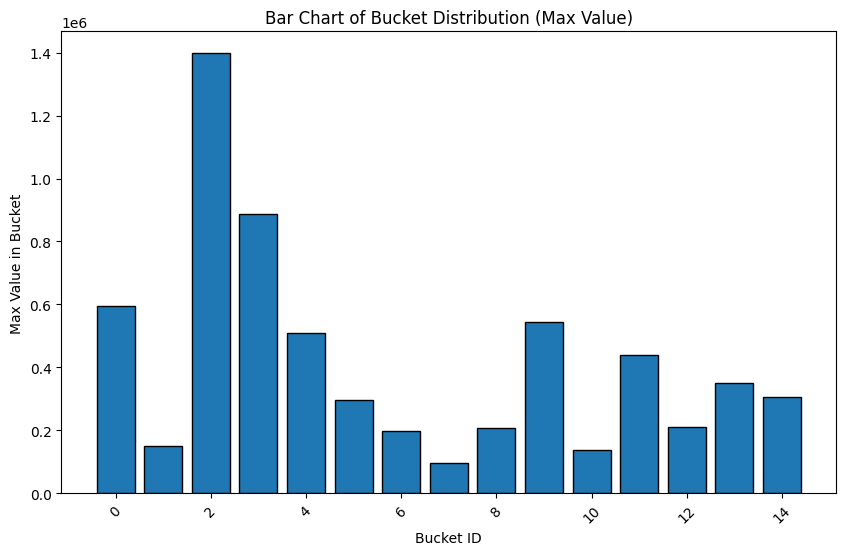

In [21]:
snapdf = pd.DataFrame(pd.DataFrame(bank.snapshot).max(), columns=['max'])
bucdf = pd.DataFrame(bank.bucket_usage_count, index=[0]).T
bucket_distribution = pd.concat([snapdf, bucdf], axis=1).rename(columns={0: 'usage_count'}).reset_index().rename(columns={'index': 'bucket_id'})

# ...existing code...
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(bucket_distribution['bucket_id'])), bucket_distribution['max'], edgecolor='black')
plt.title('Bar Chart of Bucket Distribution (Max Value)')
plt.xlabel('Bucket ID')
plt.ylabel('Max Value in Bucket')
plt.xticks(rotation=45)
plt.show()

<Axes: title={'center': 'Cumulative PnL vs Exit Time'}, xlabel='exit_time'>

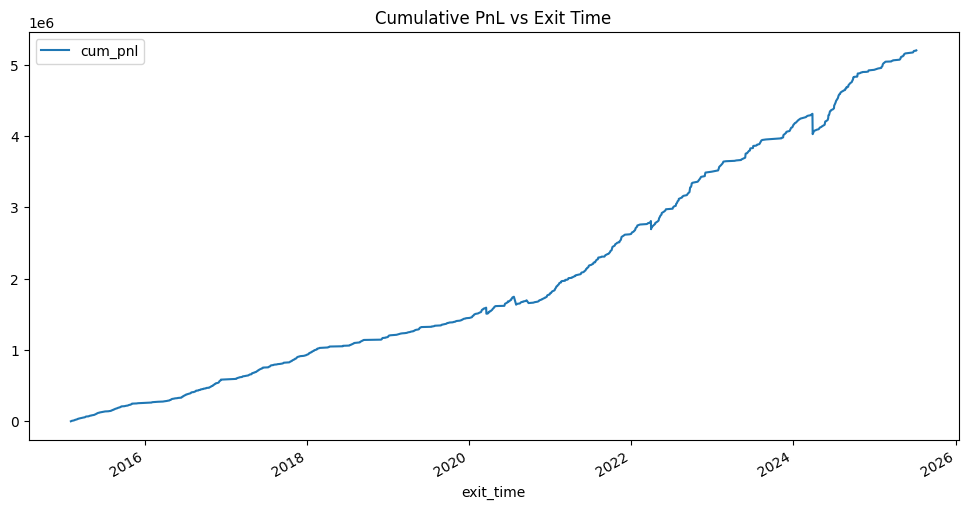

In [22]:
# ...existing code...
trades = trades.sort_values(['exit_time']).reset_index(drop=True)
trades['cum_pnl'] = trades['pnl'].cumsum()
trades.plot(x='exit_time', y='cum_pnl', title='Cumulative PnL vs Exit Time', figsize=(12, 6))

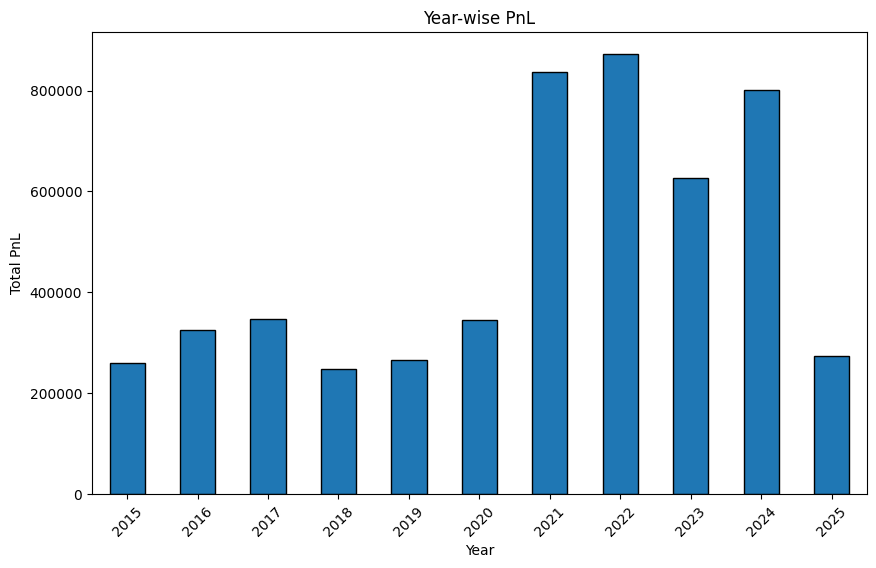

In [23]:
# ...existing code...
import matplotlib.pyplot as plt

# Extract year from exit_time
trades['exit_year'] = trades['exit_time'].dt.year

# Group by year and sum pnl
yearly_pnl = trades.groupby('exit_year')['pnl'].sum()

plt.figure(figsize=(10, 6))
yearly_pnl.plot(kind='bar', edgecolor='black')
plt.title('Year-wise PnL')
plt.xlabel('Year')
plt.ylabel('Total PnL')
plt.xticks(rotation=45)
plt.show()
#

In [24]:
losses = [c for c in pm.closed_positions if c.pnl < 0]
losses_df = pd.DataFrame([asdict(p) for p in losses]).sort_values(['entry_time']).reset_index(drop=True)
losses_df.to_csv('losses.csv', index=False)

Text(0, 0.5, 'Frequency')

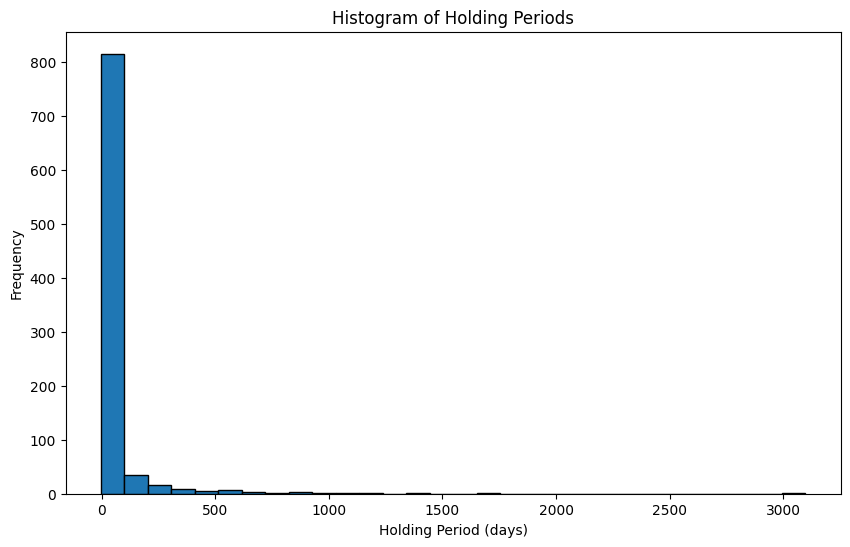

In [26]:
trades['holding_period'] = (trades['exit_time'] - trades['entry_time']).dt.days

# ...existing code...
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
trades['holding_period'].plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Holding Periods')
plt.xlabel('Holding Period (days)')
plt.ylabel('Frequency')

In [15]:
trades[trades.holding_period > 100]

,stock,entry_time,avg_entry_price,last_entry_price,quantity,exit_time,exit_price,tp,sl,trades,...,leverage,mtf_rate_daily,tp_perc,sl_perc,max_mtf_days,cum_pnl,cum_max,drawdown,exit_year,holding_period
45,NSE:ZEEL-EQ,2015-02-12 05:30:00,361.20,361.20,184,2015-05-25 05:30:00,320.05,372.541680,0.0,"[{'capital_key': '4589e1a2', 'entry_time': 201...",...,1,0.000192,3.14,100,100,9.075473e+04,1.879666e+04,-7571.600000,2015,102
52,NSE:HEROMOTOCO-EQ,2015-02-19 05:30:00,2664.95,2664.95,25,2015-06-01 05:30:00,2710.00,2748.629430,0.0,"[{'capital_key': '4589e314', 'entry_time': 201...",...,1,0.000192,3.14,100,100,9.905886e+04,1.879666e+04,-8467.185562,2015,102
70,NSE:CIPLA-EQ,2015-04-17 05:30:00,680.40,680.40,104,2015-07-27 05:30:00,675.35,701.764560,0.0,"[{'capital_key': '4589e12a', 'entry_time': 201...",...,1,0.000192,3.14,100,100,1.208386e+05,6.506380e+04,-4735.462388,2015,101
82,NSE:NTPC-EQ,2015-05-14 05:30:00,115.88,115.88,649,2015-08-24 05:30:00,96.08,119.518632,0.0,"[{'capital_key': '4589dfae', 'entry_time': 201...",...,1,0.000192,3.14,100,100,1.339547e+05,7.838553e+04,-12850.200000,2015,102
85,NSE:TATASTEEL-EQ,2015-05-22 05:30:00,34.12,34.12,2275,2015-08-31 05:30:00,22.53,35.191368,0.0,"[{'capital_key': '4589deaa', 'entry_time': 201...",...,1,0.000192,3.14,100,100,1.127585e+05,7.838553e+04,-29691.284402,2015,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,NSE:HEROMOTOCO-EQ,2024-10-11 05:30:00,5476.30,5476.30,132,2025-01-20 05:30:00,4092.10,5648.255820,0.0,"[{'capital_key': '4589df2c', 'entry_time': 202...",...,1,0.000192,3.14,100,100,3.071027e+06,3.482685e+06,-552245.953040,2025,101
1623,NSE:HDFCLIFE-EQ,2024-12-06 05:30:00,636.50,636.50,331,2025-03-17 05:30:00,629.80,656.486100,0.0,"[{'capital_key': '4589e38c', 'entry_time': 202...",...,1,0.000192,3.14,100,100,3.326194e+06,3.482685e+06,-495994.570742,2025,101
1643,NSE:TRENT-EQ,2025-01-17 05:30:00,6216.55,6216.55,33,2025-04-28 05:30:00,5209.50,6411.749670,0.0,"[{'capital_key': '4589e404', 'entry_time': 202...",...,1,0.000192,3.14,100,100,3.445631e+06,3.482685e+06,-484587.208526,2025,101
1648,NSE:TATAMOTORS-EQ,2025-01-31 05:30:00,716.10,716.10,41,2025-05-12 05:30:00,720.80,738.585540,0.0,"[{'capital_key': '4589e292', 'entry_time': 202...",...,1,0.000192,3.14,100,100,3.473468e+06,3.482685e+06,-452536.431196,2025,101
